In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt 
from PINN_Fracture import FieldPINN
from DeepONet_Fracture import PI_DeepONet1D

ModuleNotFoundError: No module named 'PINN_Fracture'

model_path model_stage2.pth
damage_final [0.         1.         0.00170883 ... 0.00170492 1.         0.        ]
stress_final [  114146.586        0.    -8282674.    ...  1055546.8          0.
 -2914092.8  ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


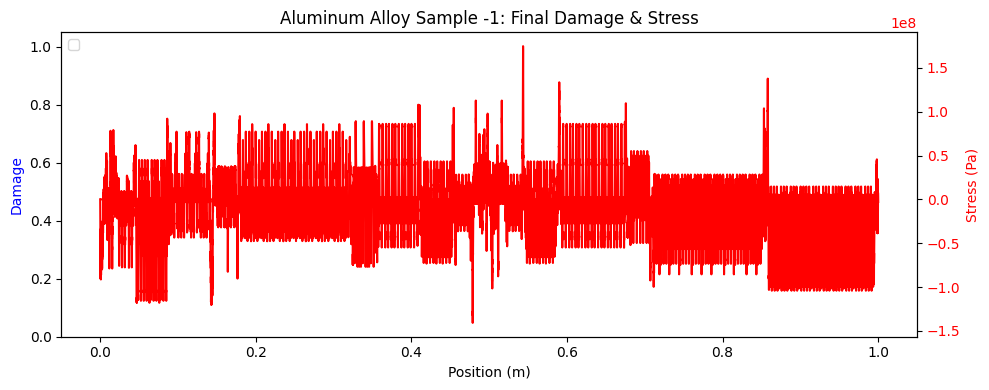

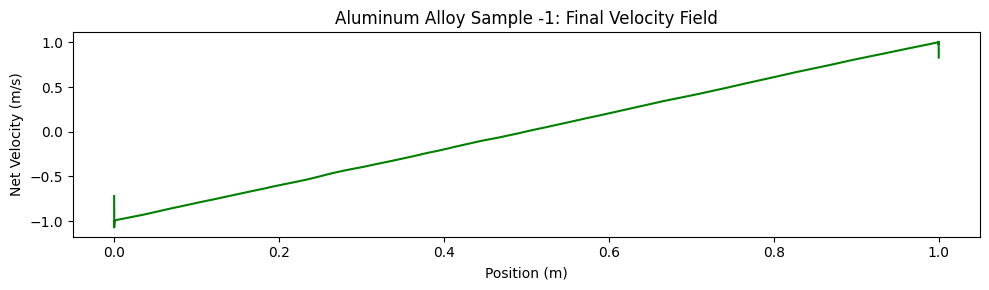

In [ ]:
#load the local model from .pth file

E_ref       = 1e11    # Pa
Gc_ref      = 1e4     # J/m^2
strength_ref= 1e9     # Pa
rho_ref     = 3000    # kg/m^3
L_phys      = 0.05    # m, same as before


path = 'fracture_results_h5/global_sensitivity_results_1.00e+04_0407.h5'
def visualize_pinn(h5_path, model_path, material, sample_idx, L=0.05):
    """
    Visualize the final damage, stress, and velocity fields for a given
    material and sample index, using uniform X over [0, L].
    """
    material_list = ["Aluminum Alloy","Titanium Alloy","CFRP","Stainless Steel",
                    "Beryllium","Glass","Copper Alloy"]
    entries = []
    f = h5py.File(h5_path, 'r')
    for mat in material_list:
        grp = f[mat]
        sr_phys = float(grp.attrs['strain_rate'])  # physical strain rate
        Nsim    = grp['damage'].shape[0]

        E_arr      = grp['E_samples'][:]
        Gc_arr     = grp['Gc_samples'][:]
        strength_arr = grp['strength_samples'][:]
        rho_arr    = grp['density_samples'][:]

        for i in range(Nsim):
            # nondimensional parameters
            E_nd       = float(E_arr[i])      / E_ref
            Gc_nd      = float(Gc_arr[i])     / Gc_ref
            strength_nd= float(strength_arr[i])/ strength_ref
            rho_nd     = float(rho_arr[i])    / rho_ref

            # nondimensional strain rate
            c_char = np.sqrt(E_arr[i] / rho_arr[i])
            tau    = L_phys / c_char
            sr_nd  = sr_phys * tau

            entries.append({
                'grp':        grp,
                'sample':     i,
                'mat_idx':    material_list.index(mat),
                'E_nd':       E_nd,
                'Gc_nd':      Gc_nd,
                'strength_nd':strength_nd,
                'rho_nd':     rho_nd,
                'sr_phys':    sr_phys,
                'sr_nd':      sr_nd,
            })
    
    
    e = entries[5]
    grp = e['grp']
    i   = e['sample']

    Nnodes = e['grp']['damage'].shape[2]
    x = torch.linspace(0, 1, Nnodes).unsqueeze(-1)

    # final snapshot
    dlen = int(grp['damage_lengths'][i])
    slen = int(grp['stress_lengths'][i])
    vlen = int(grp['velocity_lengths'][i])

    D = torch.from_numpy(grp['damage'][i, dlen-1, :].astype(np.float32))  # (N,)
    S = torch.from_numpy(grp['stress'][i, slen-1, :].astype(np.float32))
    V = torch.from_numpy(grp['velocity'][i, vlen-1, :].astype(np.float32))

    # 1) find crack‐tip index where D first exceeds 0.5
    th = 0.5
    over = (D >= th).nonzero(as_tuple=False)
    if over.numel() > 0:
        tip_idx = over[0].item()
    else:
        tip_idx = D.shape[0] - 1

    # 2) build a relative‐x grid so tip sits at 0
    x_grid = x.squeeze(-1)             # shape (N,)
    x_tip  = x_grid[tip_idx]                # scalar in [0,1]
    x_rel  = (x_grid - x_tip).unsqueeze(1)   # shape (N,1)


    # parameter tensor
    p = torch.tensor([
        e['E_nd'], e['Gc_nd'], e['strength_nd'],
        e['rho_nd'], e['sr_nd']
    ], dtype=torch.float32)
    t1 = torch.ones_like(x)
    



    # one-hot material
    print('model_path', model_path)


    modes = 128
    branch_width = 128
    trunk_width = 128
    depth = 6
    low_B = 2
    high_B = 8
    model = PI_DeepONet1D(
        param_dim   = 5,
        modes       = modes,
        branch_width= branch_width,
        trunk_channels = trunk_width,
        depth       = depth,
        # low_B       = low_B,    # coarse
        high_B      = high_B,   # fine
    )

    model.load_state_dict(torch.load(model_path))
    model.eval()
    # Create input tensor
    # input_tensor = torch.cat([X, t, p_nd, sr_nd, mat_oh], dim=1)

    damage_final = D.numpy()
    stress_final = S.numpy()
    velocity_final = V.numpy()
    p_in = p.unsqueeze(0)           # (1,5)
    x_in = x_rel.unsqueeze(0)       # (1,N,1)
    t_in = t1.unsqueeze(0)          # (1,N,1)

    model.eval()
    with torch.no_grad():
        # unpack exactly what forward returns:
        sig_raw, vel_raw, D_raw, mask_logits = model(p_in, x_in, t_in)

        # remove batch dim
        stress_final_pred = sig_raw[0].cpu().numpy()   # (N,)
        velocity_final_pred= vel_raw[0].cpu().numpy()
        damage_final_pred  = D_raw  [0].cpu().numpy()
    
    print('damage_final', damage_final)
    print('stress_final', stress_final)

    #write the damage and stress file to a .txt file
    with open('damage_stress.txt', 'w') as f:
        f.write('Damage\tStress\n')
        for d, s in zip(damage_final, stress_final):
            f.write(f'{d}\t{s}\n')

            

    # Plot on single axes with twin y-axis
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()
    # ax1.plot(x, damage_final, 'b--', label='Damage (Ground Truth)')
    # ax1.plot(x, damage_final_pred, 'b-', label='Damage (Predicted)')
    ax1.set_ylabel('Damage', color='b')
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel('Position (m)')
    
    ax2.plot(x, stress_final, 'r-', label='Stress (Ground Truth)')
    ax2.plot(x, stress_final_pred, 'r--', label='Stress (Predicted)')
    ax2.set_ylabel('Stress (Pa)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax1.set_title(f'{material} Sample {sample_idx}: Final Damage & Stress')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    plt.show()

    # Separate velocity plot
    plt.figure(figsize=(10, 3))
    plt.plot(x, velocity_final_pred, 'g-')
    plt.xlabel('Position (m)')
    plt.ylabel('Net Velocity (m/s)')
    plt.title(f'{material} Sample {sample_idx}: Final Velocity Field')
    plt.tight_layout()
    plt.show()

# Example usage:
model_path = 'model_stage2.pth'
h5_path = '1_D_Fracture/fracture_results_h5/global_sensitivity_results_3.69e+06_0407.h5'
visualize_pinn(h5_path, model_path, material='Aluminum Alloy', sample_idx=-1, L=0.05)

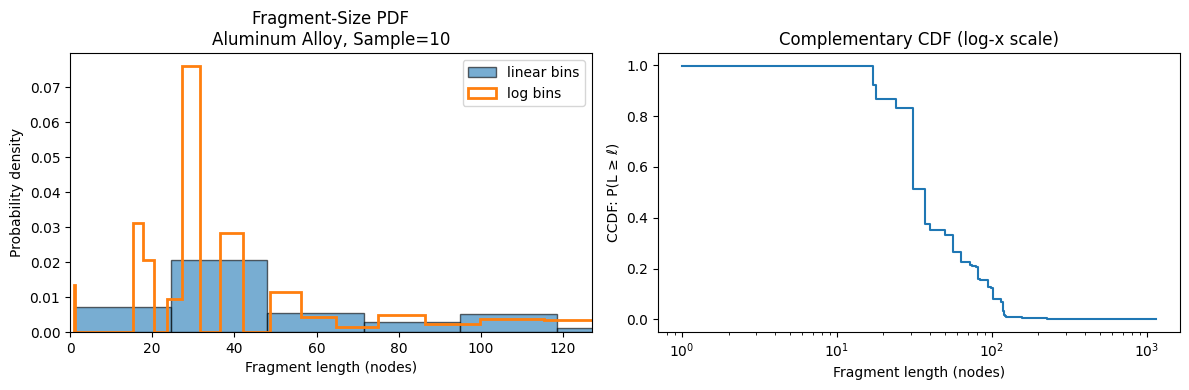

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt



def visualize_fragment_stats(h5_path, material, sample_idx, nbins=50):
    # 1) Load damage array
    with h5py.File(h5_path, 'r') as f:
        grp  = f[material]
        dlen = int(grp['damage_lengths'][sample_idx])
        D    = grp['damage'][sample_idx, dlen-1, :]

    # 2) Compute fragment lengths
    full_damage = np.where(D >= 0.999)[0]
    breaks      = np.concatenate(([-1], full_damage, [len(D)]))
    lengths     = breaks[1:] - breaks[:-1] - 1
    lengths     = lengths[lengths > 0]  # drop zero‐length “fragments” if any

    # 3a) Linear‐space histogram (PDF)
    max_len = lengths.max()
    bins_lin = np.linspace(1, max_len, nbins)

    # 3b) Log‐space histogram (PDF)
    bins_log = np.logspace(np.log10(1), np.log10(max_len), nbins)

    # 4) Complementary CDF
    sorted_l, counts = np.unique(lengths, return_counts=True)
    pdf_l           = counts / counts.sum()
    cdf_l           = np.cumsum(pdf_l)

    # 5) Plot
    fig, axs = plt.subplots(1, 2, figsize=(12,4))

    # --- Left: PDF (linear bins) ---
    axs[0].hist(lengths, bins=bins_lin, density=True,
                edgecolor='black', alpha=0.6, label='linear bins')
    axs[0].hist(lengths, bins=bins_log, density=True,
                histtype='step', lw=2, label='log bins')
    axs[0].set_xlabel('Fragment length (nodes)')
    axs[0].set_ylabel('Probability density')
    axs[0].set_xlim(0, np.percentile(lengths, 99))  # zoom in on 99th percentile
    axs[0].legend()
    axs[0].set_title(f'Fragment‐Size PDF\n{material}, Sample={sample_idx}')

    # --- Right: Complementary CDF ---
    axs[1].step(sorted_l, 1 - cdf_l, where='post')
    axs[1].set_xscale('log')
    axs[1].set_xlabel('Fragment length (nodes)')
    axs[1].set_ylabel('CCDF: P(L ≥ ℓ)')
    axs[1].set_title('Complementary CDF (log‐x scale)')

    plt.tight_layout()
    plt.show()


# Try the NumPy-based version:
visualize_fragment_stats(
    '1_D_Fracture/fracture_results_h5/global_sensitivity_results_4.22e+06_0407.h5',
    'Aluminum Alloy',
    10,
    nbins=50
)


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from MDN_Fracture import FragmentMDN, MultiFileFragmentDataset

# 1) Instantiate your dataset
file_paths    = [
    'fracture_results_h5/global_sensitivity_results_4.22e+06_0407.h5',
]
material_list = [
    "Aluminum Alloy","Titanium Alloy","CFRP","Stainless Steel",
    "Beryllium","Glass","Copper Alloy"
]
ds = MultiFileFragmentDataset(
    file_paths,
    material_list,
    # …plus whatever L_phys, E_ref, etc., your constructor needs…
)



# 5) Plot CCDF in log-log
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import Categorical, LogNormal, MixtureSameFamily

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import Categorical, LogNormal, MixtureSameFamily

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical, LogNormal, MixtureSameFamily

def plot_ccdf_with_mc_envelope(mix1: MixtureSameFamily,
                               mix2: MixtureSameFamily,
                               frag_sizes: torch.Tensor,
                               sample_idx: int = 0,
                               n_grid: int = 200,
                               M: int = 200,
                               ci: float = 0.90,
                               material: str = 'Aluminum Alloy'):
    """
    mix1, mix2 : MixtureSameFamily (batch_shape=[B])
    frag_sizes : list (or tensor) of B 1D fragment‐size tensors
    sample_idx : which sample to plot
    n_grid     : number of x points for CCDF grid
    M          : how many Monte Carlo draws per mixture
    ci         : credible interval (e.g. 0.90 for 90%)
    """
    j = sample_idx

    # --- Empirical CCDF from the j-th sample -------------------------------
    x_true   = frag_sizes[j].cpu().numpy()
    x_sorted = np.sort(x_true)
    ccdf_true = 1.0 - np.arange(len(x_sorted)) / len(x_sorted)

    # build a common log-spaced grid
    x_min, x_max = x_sorted.min(), x_sorted.max()
    x_grid = np.logspace(np.log10(x_min), np.log10(x_max), n_grid)

    # helper to get per-sample mixture and simulate CCDFs
    def _simulate_ccdfs(mix: MixtureSameFamily):
        # extract j-th mixture
        probs_j  = mix.mixture_distribution.probs[j]   # (K,)
        loc_j    = mix.component_distribution.base_dist.loc[j]
        scale_j  = mix.component_distribution.base_dist.scale[j]

        cat  = Categorical(probs=probs_j)
        ln   = LogNormal(loc_j, scale_j)
        single_mix = MixtureSameFamily(cat, ln)

        # draw M synthetic sets, each of length Nf
        Nf   = x_sorted.size
        sims = single_mix.sample((M, Nf)).cpu().numpy()  # (M, Nf)

        # compute CCDFs on x_grid
        ccdfs = np.zeros((M, n_grid))
        for m in range(M):
            xs = np.sort(sims[m])
            # fraction of fragments ≥ each grid point
            ccdfs[m] = [(xs >= xv).mean() for xv in x_grid]

        return ccdfs

    # simulate for both mixtures
    ccdfs1 = _simulate_ccdfs(mix1)
    ccdfs2 = _simulate_ccdfs(mix2)

    # envelope percentiles
    low_q, high_q = (1.0 - ci) / 2 * 100, (1.0 + ci) / 2 * 100
    env1_low  = np.percentile(ccdfs1, low_q,  axis=0)
    env1_high = np.percentile(ccdfs1, high_q, axis=0)
    env2_low  = np.percentile(ccdfs2, low_q,  axis=0)
    env2_high = np.percentile(ccdfs2, high_q, axis=0)

    # --- Plotting -----------------------------------------------------------
    plt.figure(figsize=(6,4))

    # empirical
    plt.loglog(x_sorted, ccdf_true, drawstyle='steps-post',
               color='k', label='Empirical CCDF')

    # # # mix1
    plt.loglog(x_grid, ccdfs1.mean(axis=0),
               '-', color='C1', label='Mixture mean CCDF')
    plt.fill_between(x_grid, env1_low, env1_high,
                     color='C1', alpha=0.3,
                     label=f'{int(ci*100)}% envelope Mixture 1')
    plt.title(f'{material} CCDFs')

    # mix2
    # plt.loglog(x_grid, ccdfs2.mean(axis=0),
    #            '--', color='C2', label='Mixture 2 mean CCDF')
    # plt.fill_between(x_grid, env2_low, env2_high,
    #                  color='C2', alpha=0.3,
    #                  label=f'{int(ci*100)}% envelope Mixture 2')

    plt.xlabel('Fragment size (normalized)')
    plt.ylabel('P(X ≥ x)')
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()




Material Titanium Alloy
E tensor(1.0985e+12) Gc tensor(46256.3359) strength tensor(9.0559e+08) rho tensor(4450.7134) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([344.1655], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([287.2542], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(267)


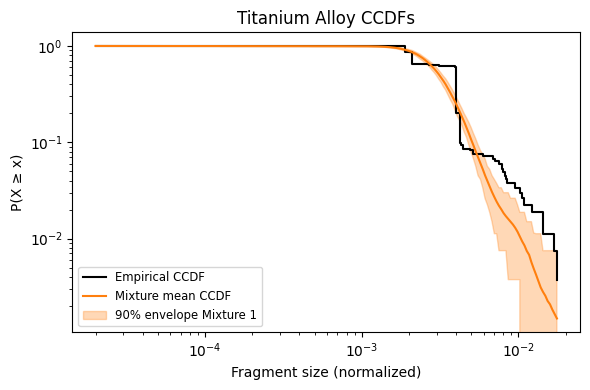

Material CFRP
E tensor(7.2544e+11) Gc tensor(750.2421) strength tensor(5.3741e+08) rho tensor(1673.9795) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([486.0424], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([445.8360], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(398)


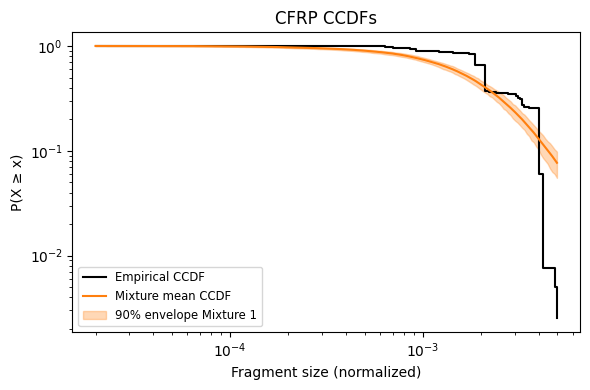

Material Stainless Steel
E tensor(1.9327e+12) Gc tensor(35479.5664) strength tensor(9.4398e+08) rho tensor(7908.3975) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([425.2123], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([332.4055], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(363)


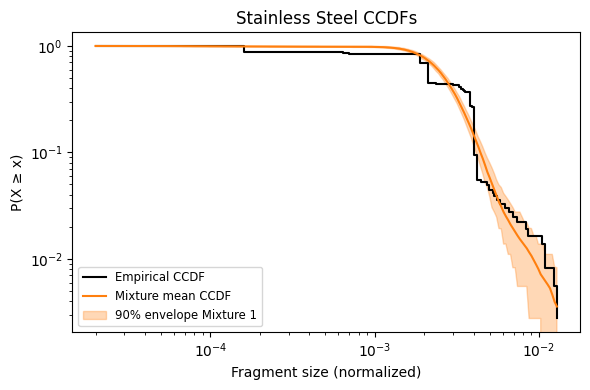

Material Beryllium
E tensor(2.9840e+12) Gc tensor(183.9416) strength tensor(3.6579e+08) rho tensor(1860.2599) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([24.4962], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([2368.3467], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(1293)


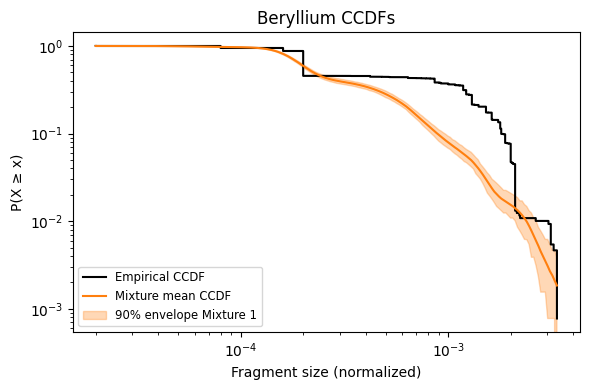

Material Glass
E tensor(6.8581e+11) Gc tensor(12.4944) strength tensor(43174056.) rho tensor(2507.3516) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([2910.8293], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([7242.3403], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(6008)


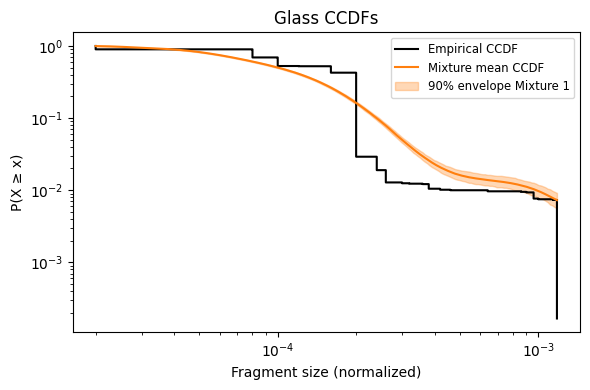

Material Copper Alloy
E tensor(1.2496e+12) Gc tensor(57540.1250) strength tensor(4.9323e+08) rho tensor(8899.5098) sr tensor(535789.4375)
Predicted # fragments per sample model_2: tensor([348.8988], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([288.5989], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(304)


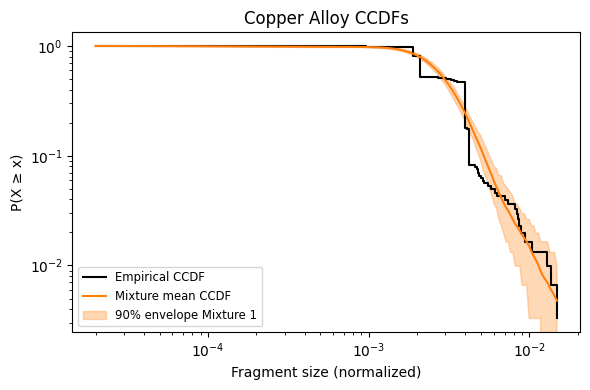

Material Aluminum Alloy
E tensor(7.2531e+11) Gc tensor(14128.7695) strength tensor(2.1091e+08) rho tensor(2715.0842) sr tensor(2638947.2500)
Predicted # fragments per sample model_2: tensor([1379.4690], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([1286.7655], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(1376)


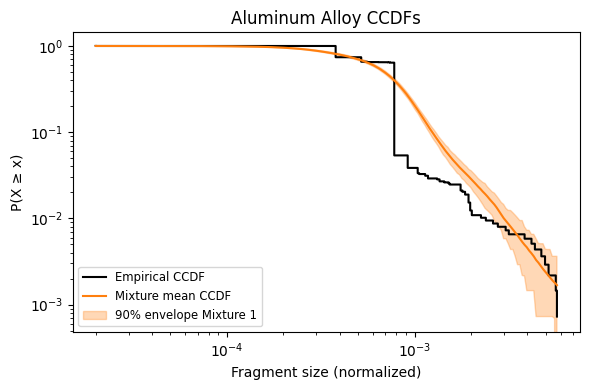

Material Titanium Alloy
E tensor(1.0242e+12) Gc tensor(31923.8398) strength tensor(9.5490e+08) rho tensor(4496.2422) sr tensor(2638947.2500)
Predicted # fragments per sample model_2: tensor([1127.9685], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([1159.9658], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(1343)


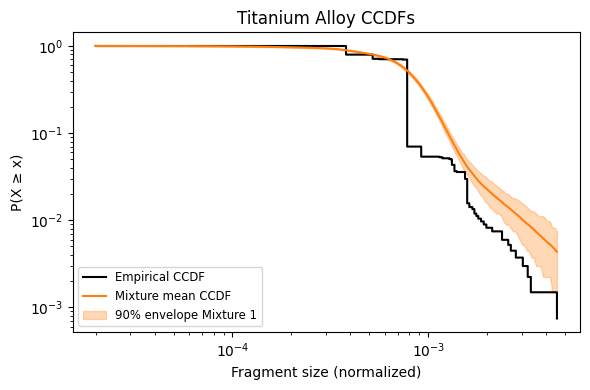

Material CFRP
E tensor(5.3652e+11) Gc tensor(873.6497) strength tensor(3.2939e+08) rho tensor(1958.3832) sr tensor(2638947.2500)
Predicted # fragments per sample model_2: tensor([6539.5591], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([3337.8562], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(3320)


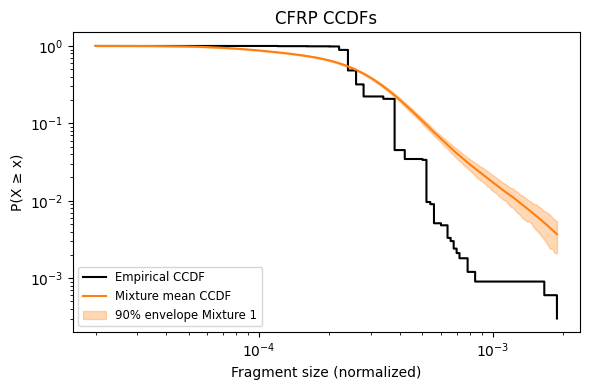

Material Stainless Steel
E tensor(2.0433e+12) Gc tensor(39596.6055) strength tensor(8.7136e+08) rho tensor(7909.7070) sr tensor(2638947.2500)
Predicted # fragments per sample model_2: tensor([1283.7783], device='cuda:0', grad_fn=<DivBackward0>)
Predicted # fragments per sample model_1: tensor([1350.9093], device='cuda:0', grad_fn=<DivBackward0>)
True # fragments per sample: tensor(1387)


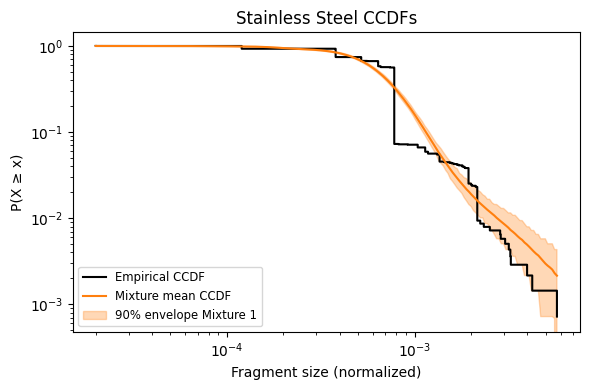

In [5]:
# 2) Load your trained model
# 1) Instantiate your dataset
import glob
E_ref        = 1e13    # Pa
Gc_ref       = 1e5     # J/m²
strength_ref = 1e10    # Pa
rho_ref      = 1e4     # kg/m³
L_phys       = 0.05    # m
sr_ref       = 1e7
file_paths    = glob.glob('fracture_results_h5/*.h5')
material_list = ["Aluminum Alloy","Titanium Alloy","CFRP","Stainless Steel",
                     "Beryllium","Glass","Copper Alloy"]
ds = MultiFileFragmentDataset(
    file_paths,
    material_list,
    # …plus whatever L_phys, E_ref, etc., your constructor needs…
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1  = FragmentMDN(in_dim=5, hidden_dim=128, n_components=32).to(device)
model2  = FragmentMDN(in_dim=5, hidden_dim=128, n_components=32).to(device)
# model = WeibullMDN(in_dim=5, hidden_dim=128, n_components=32).to(device)
model2.load_state_dict(torch.load('MDN_Fracture_32_tail.pth', map_location=device))
model1.load_state_dict(torch.load('MDN_Fracture_hidden_dim_128_components_32_batch_size_8_mass_10.0_tail_0.pth', map_location=device))
model1.eval()
model2.eval()
idx = 5000
for i in range(10):
    # 3) Grab one sample
    p, frag_sizes, N_frags, V_tot, mat = ds[idx+i*100]
    E = ds.entries[idx+i*100]['params'][0]*E_ref
    Gc = ds.entries[idx+i*100]['params'][1]*Gc_ref
    strength = ds.entries[idx+i*100]['params'][2]*strength_ref
    rho = ds.entries[idx+i*100]['params'][3]*rho_ref
    sr = ds.entries[idx+i*100]['params'][4]*sr_ref
    print("Material", ds.entries[idx+i*100]['grp'].name.split('/')[-1])
    print("E", E, "Gc", Gc, "strength", strength, "rho", rho, "sr", sr)
    p = p.unsqueeze(0).to(device)            # (1,5)
    frag_sizes_list = [frag_sizes.to(device)]  # list of length 1

    # 4) Get the mixture
    mix1 = model1(p)   # batch_shape = [1]
    mix2 = model2(p)   # batch_shape = [1]

    # 1) get mixture weights π_k and component means E[X_k]
    pi2    = mix2.mixture_distribution.probs            # shape [B,K]
    means2 = mix2.component_distribution.mean           # shape [B,K]

    # 2) compute expected fragment size E[X] = Σ π_k E[X_k]
    E_X2  = (pi2 * means2).sum(dim=-1)                   # shape [B]

    # 3) invert for count:  N_pred = V_tot / E[X]
    N_pred2 = V_tot.to(E_X2.dtype) / E_X2                 # shape [B]

    pi1   = mix1.mixture_distribution.probs            # shape [B,K]
    means1 = mix1.component_distribution.mean           # shape [B,K]
    # 2) compute expected fragment size E[X] = Σ π_k E[X_k]
    E_X1  = (pi1 * means1).sum(dim=-1)                   # shape [B]
    # 3) invert for count:  N_pred = V_tot / E[X]
    N_pred1 = V_tot.to(E_X1.dtype) / E_X1                 # shape [B]

    print("Predicted # fragments per sample model_2:", N_pred2)
    print("Predicted # fragments per sample model_1:", N_pred1)
    print("True # fragments per sample:", N_frags)
    # USAGE:
    # plot_fragment_distribution_with_uncertainty(mix, frag_sizes_list, sample_idx=0)

    # 6) Call it
    plot_ccdf_with_mc_envelope(mix1, mix2, frag_sizes_list, sample_idx=0, material=mat)



6300


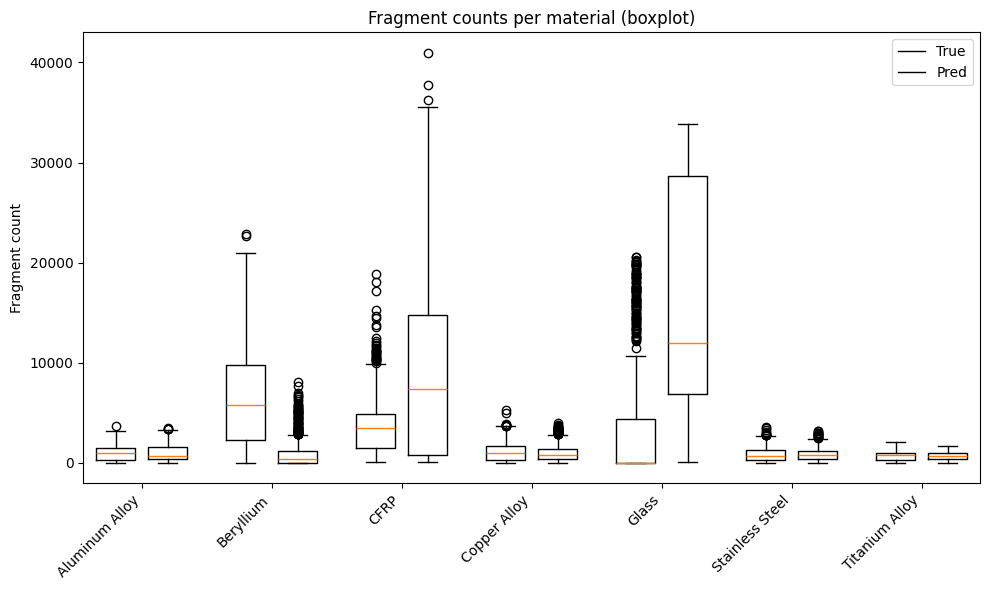

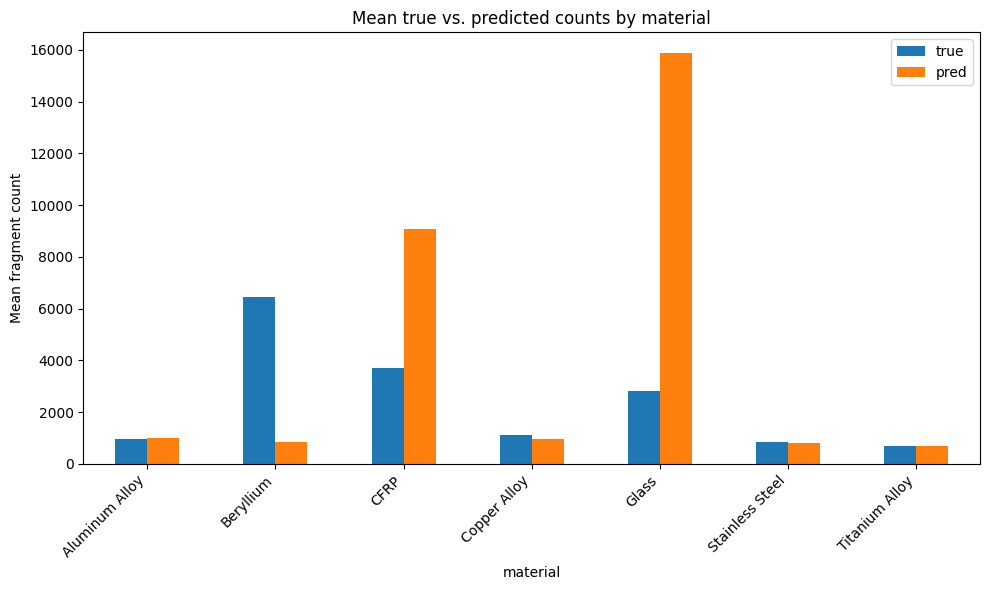

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from MDN_Fracture import FragmentMDN, MultiFileFragmentDataset
from torch.utils.data import Dataset, DataLoader

# 1) First, collect per‐sample data:
material_names = []
true_counts    = []
pred_counts    = []
print(len(ds.entries))
model2.eval()
loader = DataLoader(ds, batch_size=1, shuffle=True,
                        collate_fn=MultiFileFragmentDataset.collate_fn)
with torch.no_grad():
    for i in range(len(ds.entries)):
        params, frag_sizes, N_frags, V_tot, mat = ds[i]
        E = ds.entries[i]['params'][0]*E_ref
        Gc = ds.entries[i]['params'][1]*Gc_ref
        strength = ds.entries[i]['params'][2]*strength_ref
        rho = ds.entries[i]['params'][3]*rho_ref
        sr = ds.entries[i]['params'][4]*sr_ref
        # Assume your Dataset now also returns a list of material‐strings:
        #   e.g. Dataset.__getitem__ returns (params, frag_sizes, N_frags, V_tot, mat_name)
        # so that the DataLoader yields mat_names as well.
        params = params.to(device)
        V_tot  = V_tot.to(device)

        mix = model2(params)
        pi    = mix.mixture_distribution.probs
        means = mix.component_distribution.mean
        E_X   = (pi * means).sum(dim=-1)
        N_pred = (V_tot / E_X).cpu().numpy()

        # flatten:
        N_true = N_frags.cpu().numpy()

        # suppose mat_names is a Python list of length B
        
        material_names.append(mat)
        true_counts.append(int(N_true))
        pred_counts.append(float(N_pred))

# 2) Pack into a DataFrame
df = pd.DataFrame({
    'material': material_names,
    'true'    : true_counts,
    'pred'    : pred_counts
})

# 3a) Boxplot comparison
plt.figure(figsize=(10,6))
pos_true = np.arange(len(df['material'].unique()))*2.0
pos_pred = pos_true + 0.8

grouped = df.groupby('material')
true_data = [grouped.get_group(m)['true'].values for m in grouped.groups]
pred_data = [grouped.get_group(m)['pred'].values for m in grouped.groups]
materials = list(grouped.groups.keys())

plt.boxplot(true_data, positions=pos_true, widths=0.6)
plt.boxplot(pred_data, positions=pos_pred, widths=0.6)
plt.xticks(pos_true + 0.4, materials, rotation=45, ha='right')
plt.legend(['True', 'Pred'], loc='upper right')
plt.ylabel('Fragment count')
plt.title('Fragment counts per material (boxplot)')
plt.tight_layout()
plt.show()

# 3b) Bar plot of mean counts
means = df.groupby('material')[['true','pred']].mean()
means.plot(kind='bar', figsize=(10,6))
plt.ylabel('Mean fragment count')
plt.title('Mean true vs. predicted counts by material')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
